General imports and libraries


In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


# Markov decision process


## Creating the problem graph

<IPython.core.display.Javascript object>


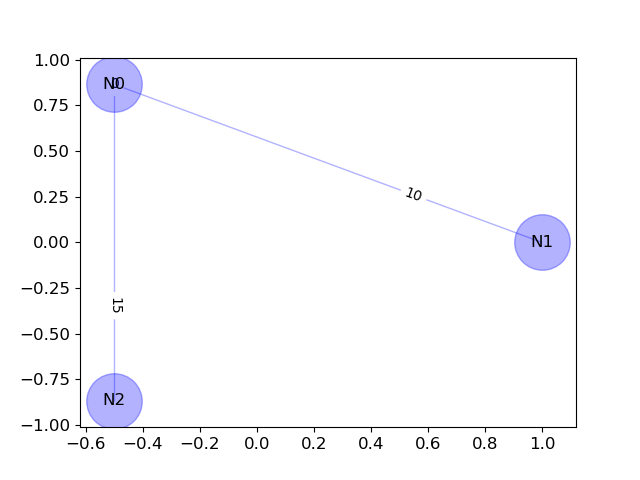

In [5]:
import networkx as nx
from graphs.utils import *
     
nodes = ["N0", "N1", "N2"]    
edges = [("N0","N0"), ("N0","N1"), ("N0", "N2")]
edge_weights = [0, 10,15] #ordered according to the edges list
node_weights = [1, 0.5,0.25] #ordered according to the node list

G = create_graph(nodes, edges, edge_weights, node_weights)

draw_graph(G, edges, edge_weights)


In [6]:
def print_node_weights(G):
    for node in G.nodes():
        print(node, G.node[node]) 
        
print_node_weights(G)        

N1 {'weight': 0.5}
N0 {'weight': 1}
N2 {'weight': 0.25}


In [7]:
# Lets update node N1 assuming it is now at the 75% of its capacity:
G.node["N1"]["weight"] = 0.75
print_node_weights(G)

N1 {'weight': 0.75}
N0 {'weight': 1}
N2 {'weight': 0.25}


In [13]:
G.edges[("N0","N0")]

{'weight': 0}

### Adjacency, incidence matrix of the graph, neighbours

In [39]:
nx.incidence_matrix(G).todense()

matrix([[1., 0., 0.],
        [1., 0., 1.],
        [0., 0., 1.]])

In [40]:
nx.incidence_matrix(G)

<3x3 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Column format>

In [53]:
print(G["N0"])

{'N1': {'weight': 10}, 'N0': {'weight': 0}, 'N2': {'weight': 15}}


In [59]:
my_dict = G["N0"]
for key in my_dict:
    print(key, my_dict[key]["weight"])

N1 10
N0 0
N2 15


## Creating the class of states and actions

In [32]:
class State():
    def __init__(self, graph, truck_positions, truck_loads, tank_levels):
        self.p = truck_positions
        self.l = truck_loads
        self.c = tank_levels
        self.tpl = (self.p, self.l, self.c)
        
        self.n = len(self.c)
        self.k = len(self.p)
        
        self.G = graph
        
    def actions(self):
        
        pass
    

In [33]:

s0 = State(G, ("N0", "N0"), (0.1,0.2), (1, 0.5, 0.5))
print(s0.tpl[1][1])
print(s0.tpl)
print(s0.n, s0.k)

0.2
(('N0', 'N0'), (0.1, 0.2), (1, 0.5, 0.5))
3 2


In [4]:


    

class MDPEnvironment(object):
    def __init__(self, start_state=0):
        self.start_state=start_state
        self.reset()
    def reset(self):
        self.total_rewards = 0
        self.state = self.start_state
        
    def reward_function(self, action):
        pass
        
    def step(self, action):
        next_state = np.random.choice(range(3), p=transition_probabilities[self.state][action])
        reward = rewards[self.state][action][next_state]
        self.state = next_state
        self.total_rewards += reward
        
        return self.state, reward


SyntaxError: invalid syntax (<ipython-input-4-34edfdef708d>, line 1)

In [ ]:
G.edges()[0]